In [213]:
# Function to take a folder path, load the behavioral and licking data. Clean it to a nice lil pandas df
def load_beh_data(path, animal_id):

    import os 
    import pandas as pd
    import numpy as np

    file_pandas = animal_id + "_df.csv"
    if os.path.isfile(file_pandas):
        beh_df = pd.read_csv(file_pandas)
    else:
    
        file_data = 'analyze_animal_'+animal_id+'.mat'
        data_path = os.path.join(path,file_data)

        beh_data = import_matlab_file(data_path)
        beh_df, ignore = pd_from_uneven_dict(beh_data['animal'])
        beh_df = beh_df.rename(columns={"lick_0": "RH", "lick_1": "LH", "lick_2": "RM", "lick_3": "LM", "lick_4": "NG"})

        boo_cols = ["RH", "LH", "RM", "LM", "NG", "LED"]
        beh_df[boo_cols] = beh_df[boo_cols].astype(bool)


        file_ttl = 'ttl_info_'+animal_id+'.mat'
        ttl_path = os.path.join(path, file_ttl)
        ttl_data = import_matlab_file(ttl_path)

        beh_df['Spout_1']= np.mean(ttl_data['trial_info']['lick'][:,750:825,0],axis = 1)
        beh_df['Spout_2'] = np.mean(ttl_data['trial_info']['lick'][:,750:825,1],axis = 1)


        file_ttl2 = 'ttl_choices_'+animal_id+'.mat'
        ttl_path2 = os.path.join(path, file_ttl2)
        ttl_data2 = import_matlab_file(ttl_path2)
        c = ttl_data2['trial_info']['choice'][:,:,750:1750]
        beh_df['latency'] = determine_latency(beh_df['rxnTime'], c)

        beh_df.to_csv(file_pandas, index= False)
        

    return beh_df

In [206]:
# Function that infers the latency of a response from the lick rasters
def determine_latency(rxn, c):
    import numpy as np
    rx = []
    for a in range(c.shape[0]):
        r = (np.argwhere(c[a,:,:]== 1))

        if r.size == 0 and rxn[a] > 0:
            rx.append(rxn[a]);
        elif r.size == 0:
            rx.append(np.nan)
            #ch.append(np.nan)
        else:
            #ch.append(r[0][0])
            rx.append(r[0][1])

    return rx

In [207]:
def import_matlab_file(file):
    from scipy.io import loadmat
    
    mat_data = loadmat(file, struct_as_record = False, squeeze_me = True, mat_dtype = True, chars_as_strings = True, simplify_cells = True)
    mat_data =  {k:v for k,v in mat_data.items() if '__' not in k};
    
    return mat_data

In [208]:
# Reorganization of dictionaries into dataframes. Used to clean up my matlab structs into df with rows corresponding to trials
def pd_from_uneven_dict(d):

    import numpy as np
    import pandas as pd
    
    shapes = [v.shape for v in d.values() if len(v.shape) == 1]
    trials = max(shapes)[0]

    single_dim = {k:v for k,v in d.items() if (len(v.shape) == 1)  & (trials == v.shape[0])};
    df = pd.DataFrame(single_dim);

    remainder = {};

    for k,v in d.items():
        
        if len(v.shape)  ==  3:
            split_data = np.dsplit(v, v.shape[2]);
            for ind, dim in enumerate(split_data):
                col_name = k + "_"+f'{ind}';
                if dim.shape[0] == trials:
                    df[col_name] = list(np.squeeze(dim))
                else:
                    df[col_name] = list(np.squeeze(dim.transpose))
        elif len(v.shape) == 2:
            if v.shape[1] == trials:
                v = v.transpose()

            if v.shape[1] < 10:
                for i, j in enumerate(v.transpose()):
                        col_name = k + "_" + f'{i}'
                        
                        df[col_name] = j
            else:
                col_name = k
                df[col_name] = list(np.squeeze(v))
                
        elif (len(v.shape) == 1)  & (trials != v.shape[0]):
            remainder[k] = v;

        
            
    return df, remainder

In [209]:
# function to take beh_df and processes the data into the form for modeling. Keep as a dataframe to 
# allow for easier subsampling of trials. Next steps: incorporate a function that allows for easy sampling
# of trial history
def clean_beh_data(b):
    import numpy as np
    import pandas as pd

    
    b2 = pd.DataFrame()
    ns = np.array(np.append(1, np.diff(b['sessionNum'])), dtype = bool)

    b2['Rightward'] = (b['RH'] | b['LM']).astype(int)
    pr = np.concatenate(([0], b2['Rightward'][:-1].values));
    pr[ns] = 0;
    b2['Previous_rightward'] = pr;

    b2['Correct'] = (b['RH'] | b['LH']).astype(int)
    pc = np.concatenate(([0], b2['Correct'][:-1].values))  
    pc[ns] = 0;
    b2['Previous_correct'] = pc;

    b2['Stimulus'] =np.log2(b['stimulus']/8)/2
    b2['LED'] = b['LED'].astype(int);
    b2['Target'] = b['target'].astype(int);
    b2['Session'] = b['sessionNum'];

   
    b2['Latency'] = b['latency']/1000;
    #b2['New_session']= ns;
   
    go = (b['RH'] | b['LM'] | b['RM'] | b['LH']).values
    
    b2 = b2.iloc[go,:]
    
    return b2

In [210]:
def expand_history(d, back):
    import numpy as np
    d = np.expand_dims(d, axis = 1)

    for _ in range(back):
        add = np.r_[0, d[:-1, -1]]
        d = np.c_[d, add]

    return d


In [211]:

from matplotlib import pyplot as plt
plt.imshow(d[:25, :])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [251]:
import os
path = os.getcwd();

animal = 'opto_69'

b = load_beh_data(path, animal)


In [252]:
b2 = clean_beh_data(b)
b2.head()

,Rightward,Previous_rightward,Correct,Previous_correct,Stimulus,LED,Target,Session,Latency
71,1,0,1,0,1.0,0,1,1.0,0.867
72,1,1,1,1,1.0,0,1,1.0,0.845
75,1,0,1,0,1.0,0,1,1.0,0.942
76,1,1,1,1,1.0,0,1,1.0,0.886
82,1,0,1,0,1.0,0,1,1.0,1.051


In [253]:
import numpy as np
inputs = ['Previous_rightward', 'Previous_correct', 'Stimulus', 'Latency']
dat = np.array(b2[inputs])

d = np.array(b2['Previous_correct'])
d.shape

(9151,)

In [254]:
previous_choice = expand_history(np.array(b2['Previous_rightward']), 4)
inputs = ['Previous_correct', 'Stimulus', 'Latency']
others = np.array(b2[inputs])

X = np.c_[np.ones((others.shape[0], 1)), others, previous_choice]
y = b2['Rightward']

X1 = X[b2['LED'].astype(bool),:]
X2 = X[~b2['LED'].astype(bool),:]
y1 = y[b2['LED'].astype(bool)]
y2 = y[~b2['LED'].astype(bool)]

In [258]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.33)


In [260]:
from sklearn.linear_model import LogisticRegression
logR = LogisticRegression();
logR.fit(X_train, y_train)
pred = logR.predict(X_test)

0.8194552529182879

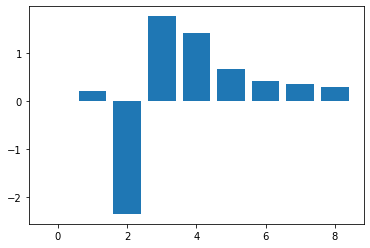

In [257]:
plt.bar([0,1,2,3,4,5,6,7,8],  logR.coef_[0])
logR.score(X_test, y_test)
# x2 no LED

0.7893569844789357

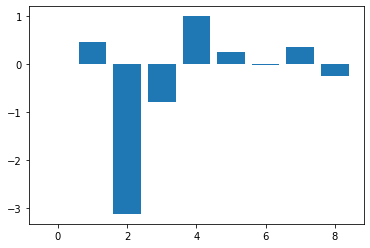

In [261]:
plt.bar([0,1,2,3,4,5,6,7,8],  logR.coef_[0])
logR.score(X_test, y_test)
# x1 LED

In [144]:
logR.coef_

array([[1.82581369e-05, 1.42439620e-01, 1.17917516e+00, 5.94713392e-01,
        8.72454661e-01, 1.03058704e-01, 3.20234120e-01, 1.41689029e-01,
        2.11926709e-01]])

In [183]:
y_train

10799    0
8138     0
6116     1
4144     0
2569     1
        ..
4872     0
6478     0
7067     1
3239     1
8662     0
Name: Rightward, Length: 982, dtype: int64